In [23]:
#https://github.com/InsulatorData/InsulatorDataSet
#https://universe.roboflow.com/mingrui-yu/insulatordataset-nmard/dataset/1/download - он же.

In [1]:
%load_ext autoreload
from torchvision.datasets import VOCDetection
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import os
from pathlib import Path
import torchvision.datasets as datasets
import torchvision

import torch
from PIL import Image
import numpy as np
import cv2
from torch.utils.data import Dataset, DataLoader
from torchvision.ops.boxes import nms

from torchmetrics.detection.mean_ap import MeanAveragePrecision


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [25]:
train_dataset = VOCDetection(str('../input/insulatordataset/InsulatorDataSet/Normal_Insulators'),year="2007",image_set='train')
val_dataset = VOCDetection(str('../input/insulatordataset/InsulatorDataSet/Normal_Insulators'),year="2007",image_set='test')


In [26]:
train_dataset

Dataset VOCDetection
    Number of datapoints: 449
    Root location: ../input/insulatordataset/InsulatorDataSet/Normal_Insulators

In [27]:
# from os import listdir
# from os.path import isfile, join
# mypath = '/home/serhio/Data/1Education/Hack_Insulators/InsulatorDataSet/Normal_Insulators/VOCdevkit/VOC2007/JPEGImages'#str(Path(os.getcwd())/'InsulatorDataSet/Normal_Insulators')
# onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
# for x in onlyfiles:
#     print(x[:-4])

In [28]:
def create_model(num_classes, pretrained=False):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=pretrained)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [29]:
info = train_dataset[2][1]
info['annotation']['object']

[{'name': 'insulator',
  'pose': 'Unspecified',
  'truncated': '0',
  'difficult': '0',
  'bndbox': {'xmin': '131', 'ymin': '333', 'xmax': '888', 'ymax': '483'}},
 {'name': 'insulator',
  'pose': 'Unspecified',
  'truncated': '0',
  'difficult': '0',
  'bndbox': {'xmin': '374', 'ymin': '542', 'xmax': '908', 'ymax': '681'}}]

In [30]:
def pil_to_tensor(pil_image):
    return torch.from_numpy(np.asarray(pil_image)/255).permute(2, 0, 1).to(torch.float)


def info_to_dict(info):
    boxes = []
    objects_cnt = len(info['annotation']['object'])
    for object_dict in info['annotation']['object']:  # ['xmin', 'ymin', 'xmax' , 'ymax']
        # raise ValueError(object_dict)
        bbox = [
            int(object_dict['bndbox']['xmin']),
            int(object_dict['bndbox']['ymin']),
            int(object_dict['bndbox']['xmax']),
            int(object_dict['bndbox']['ymax'])
        ]
        boxes.append(bbox)
    # raise ValueError(boxes)
    boxes = torch.Tensor(boxes).to(torch.float)
    labels = torch.Tensor([1]*objects_cnt).to(torch.int64)
    return {'boxes': boxes, 'labels': labels}


info_to_dict(train_dataset[0][1])

{'boxes': tensor([[  84.,  260., 1044.,  520.]]), 'labels': tensor([1])}

In [31]:
# from PIL import Image


# def show_object_rect(image: np.ndarray, bndbox):
#     pt1 = bndbox[:2]
#     pt2 = bndbox[2:]
#     image_show = image
#     return cv2.rectangle(image_show, pt1, pt2, (0, 255, 255), 2)


# def show_object_name(image: np.ndarray, name: str, p_tl):
#     return cv2.putText(image, name, p_tl, 1, 1, (255, 0, 0))


# voc_trainset = ds
# for i, sample in enumerate(voc_trainset, 1):
#     image, annotation = sample[0], sample[1]['annotation']
#     objects = annotation['object']
#     show_image = np.array(image)
#     # print('{} object:{}'.format(i, len(objects)))
#     if not isinstance(objects, list):
#         object_name = objects['name']
#         object_bndbox = objects['bndbox']
#         x_min = int(object_bndbox['xmin'])
#         y_min = int(object_bndbox['ymin'])
#         x_max = int(object_bndbox['xmax'])
#         y_max = int(object_bndbox['ymax'])
#         show_image = show_object_rect(show_image, (x_min, y_min, x_max, y_max))
#         show_image = show_object_name(show_image, object_name, (x_min, y_min))
#     else:
#         for j in objects:
#             object_name = j['name']
#             object_bndbox = j['bndbox']
#             x_min = int(object_bndbox['xmin'])
#             y_min = int(object_bndbox['ymin'])
#             x_max = int(object_bndbox['xmax'])
#             y_max = int(object_bndbox['ymax'])
#             show_image = show_object_rect(
#                 show_image, (x_min, y_min, x_max, y_max))
#             show_image = show_object_name(
#                 show_image, object_name, (x_min, y_min))

#     # Image.fromarray(show_image).show()
#     # img = cv2.cvtColor(show_image, cv2.COLOR_BGR2RGB)
#     # im_pil = Image.fromarray(img)
#     # im_pil.show()
#     cv2.imshow('image', show_image)
#     cv2.waitKey(0)


# print(voc_trainset)
# print('Down load ok')

In [32]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [33]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = create_model(num_classes=2, pretrained=False).to(device)
#optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=0.0005)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.0005)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

# train_dataset = MyDataset(df_train, '/content/table-detection-dataset/images')
# val_dataset = MyDataset(df_val, '/content/table-detection-dataset/images')

train_data_loader = DataLoader(
    train_dataset,
    batch_size=3,
    shuffle=True,
    collate_fn=collate_fn
)

val_data_loader = DataLoader(
    val_dataset,
    batch_size=3,
    shuffle=False,
    collate_fn=collate_fn
)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [34]:
def train(train_dataloader): 
    model.train()
    running_loss = 0
    for i, data in enumerate(train_dataloader):
        optimizer.zero_grad()
        images, targets = data[0], data[1]
        images = map(pil_to_tensor, images)
        targets = map(info_to_dict, targets)
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
        if i % 50 == 0:
            print(f"\tИтерация (батч) #{i} loss: {loss}")
    train_loss = running_loss/len(train_dataloader.dataset)
    return train_loss

def val(val_dataloader):
    running_loss = 0
    for data in val_dataloader:
        optimizer.zero_grad()
        images, targets = data[0], data[1]
        images = map(pil_to_tensor, images)
        targets = map(info_to_dict, targets)
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        with torch.no_grad():
            loss_dict = model(images, targets)
        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        running_loss += loss.item()
    val_loss = running_loss/len(val_dataloader.dataset)
    return val_loss 

In [35]:
import time


train_losses = []
val_losses = []
try:
    for epoch in range(20):
        start = time.time()
        train_loss = train(train_data_loader)
        val_loss = val(val_data_loader)
        scheduler.step()
        print(f"Эпоха #{epoch} train_loss: {train_loss}, val_loss: {val_loss}")  
        end = time.time()
        print(f"Потрачено {round((end - start) / 60, 1)} минут на {epoch} эпоху")
        train_losses.append(train_loss)
        val_losses.append(val_loss)
#         metric = MeanAveragePrecision()
#         metric.update(preds, target)
except KeyboardInterrupt:
    print('Прервано пользователем')

	Итерация (батч) #0 loss: 1.5965864658355713
Прервано пользователем


In [36]:
import matplotlib.pyplot as plt

In [37]:
train_losses

[]

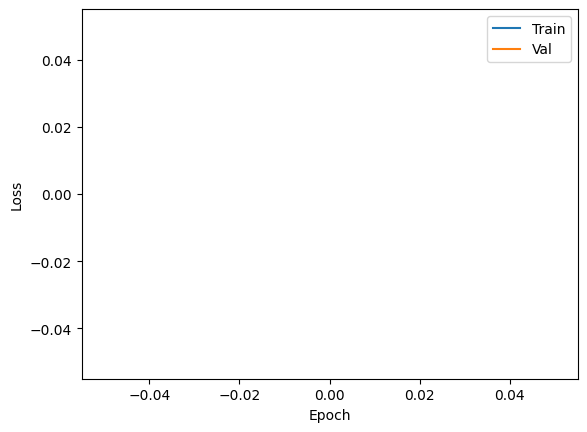

In [38]:
fig, ax  = plt.subplots()
ax.plot(train_losses, label='Train')
ax.plot(val_losses, label='Val')
ax.set(xlabel='Epoch', ylabel='Loss')
ax.legend()

In [39]:
# def draw_predict(df_index, iou_threshold=0.1, threshold=0.8, scale_percent=25):
#     model.eval()
#     img = cv2.imread(os.path.join('/content/table-detection-dataset/images',
#                                   df_val.loc[df_index, 'filename']))
#     img_ = img / 255.
#     img_ = torch.from_numpy(img_).permute(2, 0, 1).unsqueeze(0).to(torch.float).to(device)
#     predict = model(img_)
#     ind = nms(predict[0]['boxes'], predict[0]['scores'], iou_threshold).detach().cpu().numpy()
#     for i, box in enumerate(predict[0]['boxes'][ind]):
#         if predict[0]['scores'][i] > threshold:
#             cv2.rectangle(img, 
#                     (int(box[0]), int(box[1])), 
#                     (int(box[2]), int(box[3])), 
#                     (255, 0, 0), 5)
#     width = int(img.shape[1] * scale_percent / 100)
#     height = int(img.shape[0] * scale_percent / 100)
#     dim = (width, height)   
#     img = cv2.resize(img, dim)
#     cv2_imshow(img)
# draw_predict(63, 0.1)

In [41]:
iou_threshold=0.1
threshold=0.8
scale_percent=75
def draw(obj):
    model.eval()
    img_pil, info = obj
    img = np.asarray(img_pil)
    img_ = img/ 255.
    img_ = torch.from_numpy(img_).permute(2, 0, 1).unsqueeze(0).to(torch.float).to(device)
    predict = model(img_)
    ind = nms(predict[0]['boxes'], predict[0]['scores'], iou_threshold).detach().cpu().numpy()
    for i, box in enumerate(predict[0]['boxes'][ind]):
            if predict[0]['scores'][i] > threshold:
                cv2.rectangle(img, 
                        (int(box[0]), int(box[1])), 
                        (int(box[2]), int(box[3])), 
                        (255, 0, 0), 5)
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)   
    img = cv2.resize(img, dim)
    # cv2_imshow(img)
    PIL_image = Image.fromarray(img.astype('uint8'), 'RGB')
    PIL_image.show()
    return PIL_image

from IPython.display import display
for x in range(5):
    display(draw(val_dataset[x]))

In [42]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu